This has code from online examples with landlab
see other rain_sample_topo file for a more integrated rain and overland flow model

In [281]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 

from random import randint
## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 

%matplotlib inline

101
None


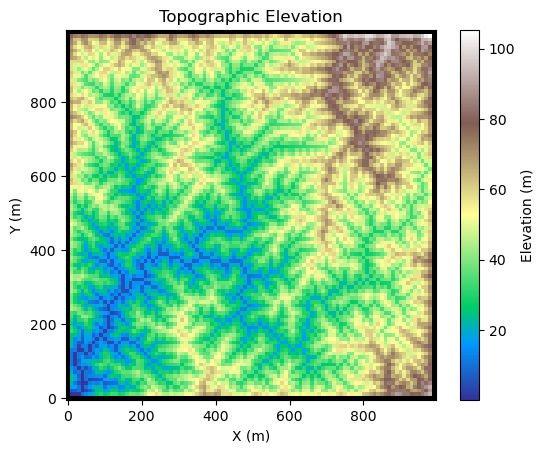

In [282]:
ncols = 100
nrows = 100
cellsize = 10

#mg = RasterModelGrid()
#Set directory paths to retrieve the asc file
#path_project = r"C:/Users/gsbir/Documents/EES_393/Export/" # add the path to the asc file    #this should access my H drive
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
#soil_dem = "sample_topo2_soil__depth.txt"
#bedrock_dem = "sample_topo2_bedrock__elevation.txt"
topo_path = topo_dem
#soil_path = path_project + soil_dem
#bedrock_path = path_project + bedrock_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
topo_header = read_asc_header(open(topo_path, 'r'))
#soil_header = read_asc_header(open(soil_path, 'r'))
#bedrock_header = read_asc_header(open(bedrock_path, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0)
#(mg, x) = read_esri_ascii(soil_path, name= 'soil__depth', halo = 1)
#(mg, y) = read_esri_ascii(bedrock_path, name= 'bedrock__elevation', halo = 1)

#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
#outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)


#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)#Close all model boundary edges


#find min elevation
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()

min_topo_ID = open_nodes[min_topo]

print(min_topo_ID)


#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999.)
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id
outlet_id = min_topo_ID
#print(mg.at_node.keys()) #Shows the node attributes

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

#imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [283]:
#ADDING REST OF THE FIELDS
#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']
#mg.at_node["bedrock__elevation"][:] -= mg.at_node['soil__depth']

mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
#Add field 'bedrock__elevation' to the grid
mg.add_zeros('surface_water__depth', at='node')
print(outlet_id)


101


Setting Up Rain and Overland Flow Parameters

In [284]:
of = OverlandFlow(mg, steep_slopes=True)
rain = SpatialPrecipitationDistribution(mg, number_of_years=1)
#storm_t = 1.5 #durration of a storm in hr
#interstorm_t = 8 #time between storms in hr
rain.total_time = 10 #this is for the rain.yield_storms (hr)
of_total_time = 3600 * 8#my own variable for how long overland flow runs in (s) -> 3600 s in 1 h



use precipitation component

the following code created a series of random storm events ( diff amt of storms each iteration )
- each plot produced is one storms' rainfall

3.61861649125
10


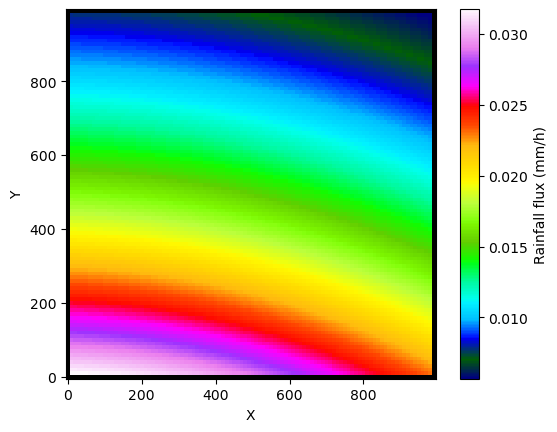

4.16683872632
10


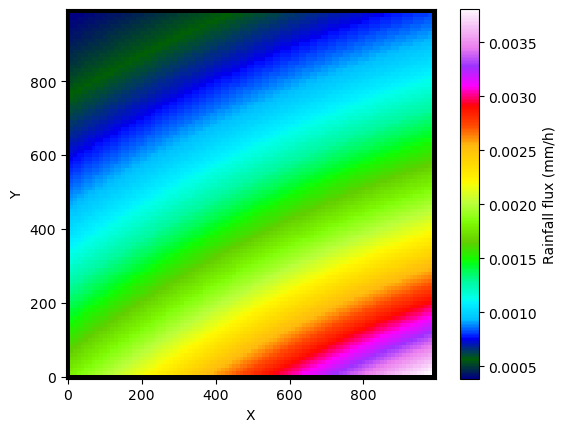

17.3101313162
10


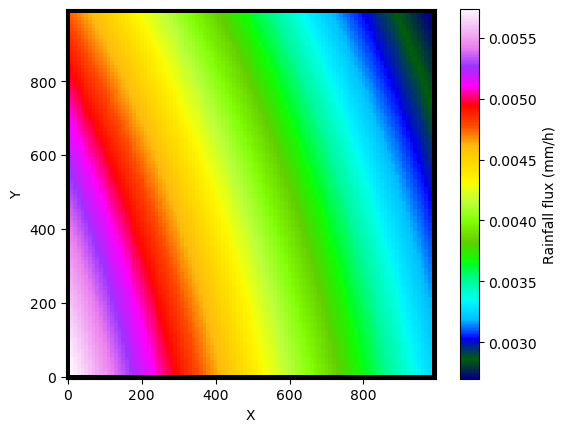

19.7306705564
10


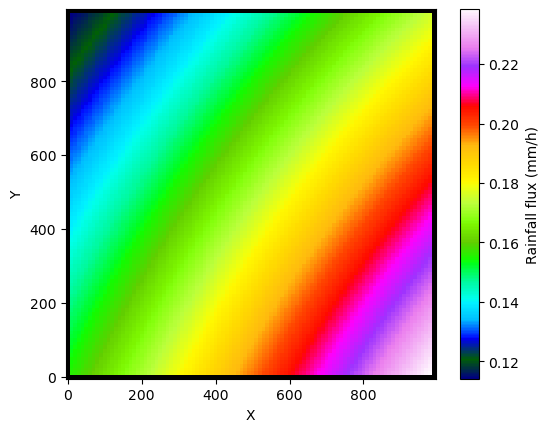

58.7373124461
10


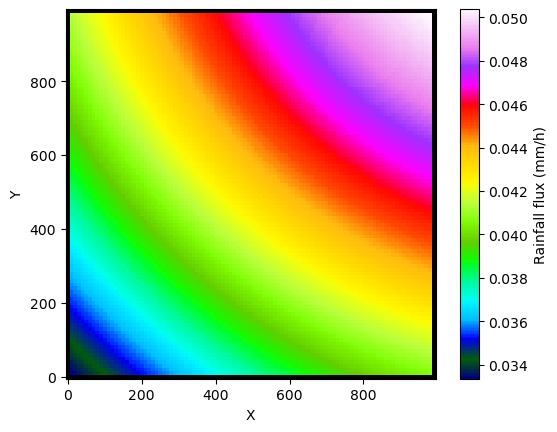

In [285]:

np.random.seed(randint(0, 100)) 

# get the storm simulator to provide a storm

storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
x = 1 #to keep track of each iteration of loop


#this is running for a year
for (storm_t, interstorm_t) in rain.yield_storms(style="whole_year"):  # storm lengths in hrs
    
    storm_time_data.append(storm_t)
    interstorm_time_data.append(interstorm_t*.041)
    storm_amt_data.append(x)
    mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    mg.at_node['rainfall__flux'] *= 2.0  # to make the storm heavier
    print(rain.median_total_rainfall_this_year)
    print(rain.total_time)
    plt.figure()# plot up this storm
    imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    plt.show()
    x+=1

PLOT OVERALL PRECIPITATION TIME VS. STORM LENGTH

each dot on the graph corresponds to a rainflux plot above

[0.48402276055240262, 0.77945597004443123, 6.401134312963328, 0.028314883882844987, 1.817314090496494]


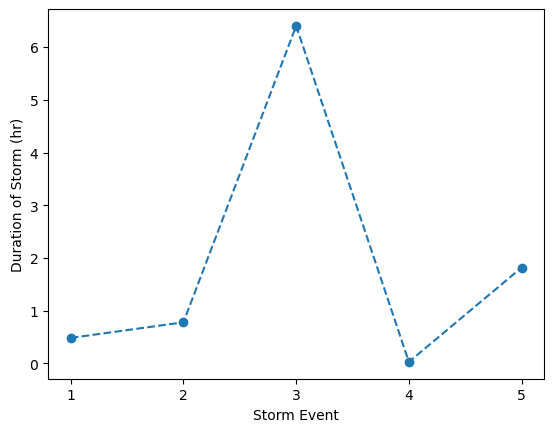

In [286]:
#show graphs of storm time and interstorm data
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, storm_time_data,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Duration of Storm (hr)")
plt.xticks(np.arange(1,x,1))
print(storm_time_data)
total_t_check = sum(storm_time_data)

PLOT OVERALL PRECIPITATION TIME VS. INTERSTORM TIME

[150.82735506681735, 48.182493131563966, 0.0, 80.364351750383008, 79.395880128500181]
368.280322095


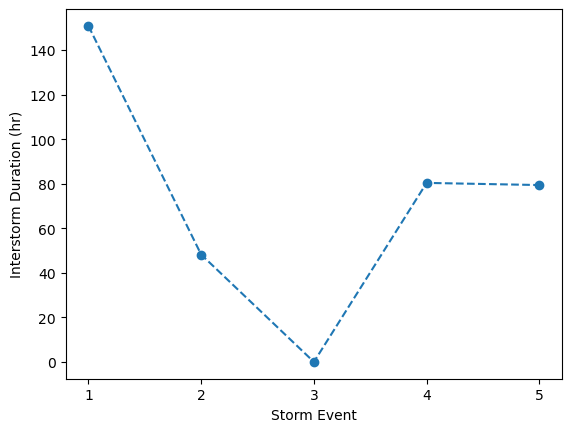

In [287]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, interstorm_time_data,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Interstorm Duration (hr)")
plt.xticks(np.arange(1,x,1))
print(interstorm_time_data)
total_t_check += sum(interstorm_time_data)
print(total_t_check)

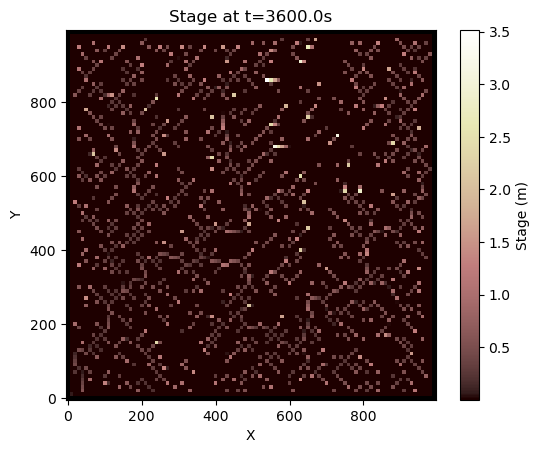

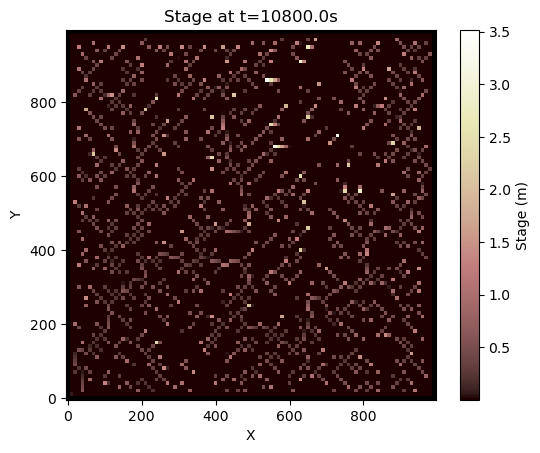

In [288]:

mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * storm_t
    # storm_t here is the duration of the rainfall, from the rainfall component
    # We're going to assume the rainfall arrives effectively instantaneously, but
    # adding discharge during the run is completely viable

node_of_max_q = outlet_id #this is discharge point 
outlet_depth = []
outlet_times = []
post_storm_elapsed_time = x #(s)
last_storm_loop_tracker = 1

while post_storm_elapsed_time < of_total_time:  #time in (s)
    dt = of.calc_time_step()
    of.run_one_step(dt=dt)
    post_storm_elapsed_time += dt
    storm_loop_tracker = post_storm_elapsed_time % 3600.  # show every 3 min
        # NB: Do NOT allow this plotting if there are multiple files in the folder
    if storm_loop_tracker < last_storm_loop_tracker:
        #Instantiate figure as empty plot
        figelev = plt.figure()

        #Instantiate subplot as empty plot
        plot = plt.subplot()
        imshow_grid(mg,'surface_water__depth',var_name='Stage (m)')
        plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
        plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(post_storm_elapsed_time)

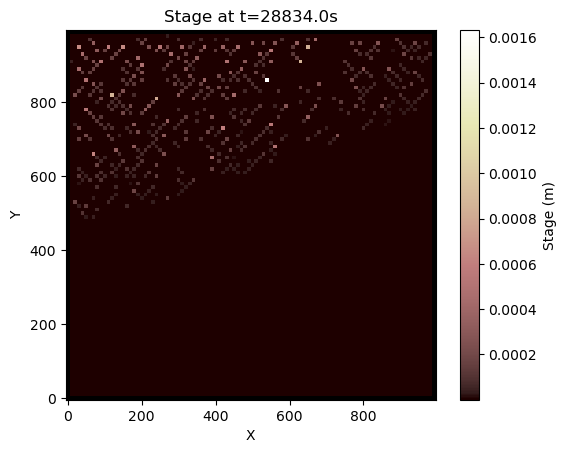

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
imshow_grid(mg,'surface_water__depth',var_name='Stage (m)')
plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
plt.show()

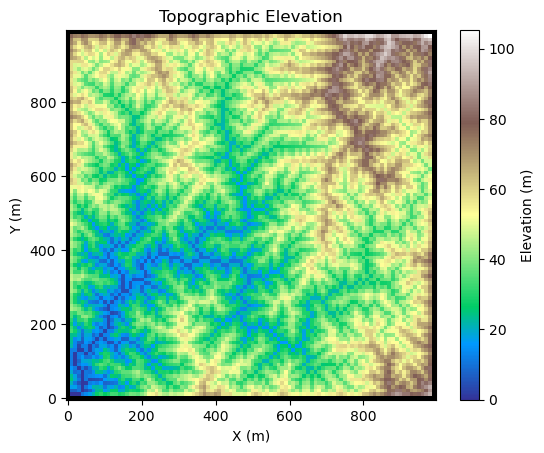

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)